# Import Libararies

In [1]:
from pathlib import Path
import datetime
import pandas as pd
import plotly.express as px
from pycaret.regression import *

In [2]:
# create data folder
current_dir = Path.cwd()
DATAPATH = current_dir.parents[0] / 'data'
Path(DATAPATH).mkdir(parents=True, exist_ok=True)

# Utility Functions

In [3]:
# filter by country
def add_date_to_filename(filename)->str:
    """Add current date to filename"""
    date = datetime.datetime.now()
    date_today = str(date.year)+'-'+str("{:02d}".format(date.month))+'-'+str("{:02d}".format(date.day))
    filename_new = filename + '_' + date_today + '.csv'
    return filename_new

def download_data(url_data, features)->pd.DataFrame:
    """download latest covid data from https://ourworldindata.org and return . Provide the url and the features you want."""
    df = pd.read_csv(url_data, usecols = features)
    # reorder columns
    df = df[features]
    # set date as index
    df.set_index('date', inplace=True)
    # Converting date to index
    df.index = pd.to_datetime(df.index)
    # check number of unique countries
    print('The dataset contains {} different countries'.format(df['location'].nunique())) 
    # check data type
    print('data types: ', df.dtypes)
    return df

def filter_country(dataframe:pd.DataFrame, LOCATION:str):
  """Filter dataframe by country. """
  return dataframe[dataframe.location == LOCATION]

def ts_filling(df_country:pd.DataFrame)->pd.DataFrame:
    """Fill missing data and smooth ts in dataframe of single country"""
    # backfill missing data by 2 months
    df = df_country.copy()
    df.fillna(value=None, method='bfill', axis=0, inplace=True, limit=80, downcast=None)
    # forwardfill missing data by 2 months
    df.fillna(value=None, method='ffill', axis=0, inplace=True, limit=80, downcast=None)
    # smooth time series
    for col in df.columns[1:]:
        df[col] = df[col].rolling(21).median()
    # fill in new nas
    df.fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
    return df

def add_new_deaths_pct_change(df_country:pd.DataFrame)->pd.DataFrame:
    """calculate percent change between the median number of deaths 14 days earlier and the median number of deaths today"""
    df = df_country.copy()
    df['new_deaths_per_million_pct_change'] = df['new_deaths_per_million'].pct_change(periods=14, fill_method='pad', freq='D')
    df['new_deaths_per_million_pct_change'].fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
    #df.dropna(axis=0, inplace=True)
    return df

def add_case_fatality_rate(df_country:pd.DataFrame)->pd.DataFrame:
    """calculate case fatality rate CFR for single country df; CFR is the ratio between the 14-day median number of deaths and the 14-day median number of cases 14 days earlier """
    df = df_country.copy()
    df['case_fatality_rate'] = df['new_deaths_per_million'] / df['new_cases_per_million'].shift(14)
    # set inf values to zero i.e. the assumption is when there are no cases then there are no deaths
    df['case_fatality_rate'][df['new_cases_per_million']==0] = 0
    # set na values to zero i.e. the assumption is when there are no deaths and at the same time zero cases, then CFR is still zero
    df['case_fatality_rate'][df['new_deaths_per_million']==0] = 0
    # cfr above 100% makes no sense
    df['case_fatality_rate'][df['case_fatality_rate']>1] = 1
    # do a little smoothing i.e. average over 7 days
    df['case_fatality_rate'] = df['case_fatality_rate'].rolling(7).median()
    # fill in new nas
    df['case_fatality_rate'].fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
    #df.dropna(axis=0, inplace=True)
    return df

# filter by date
def filter_date(dataframe:pd.DataFrame, start_date:str, end_date:str)->pd.DataFrame:
    """Filter dataframe by date range including start_date and end_date. """
    return dataframe.loc[(dataframe.index >= start_date) & (dataframe.index <= end_date)]

def get_start_end_date(df_country:pd.DataFrame)->str:
    """Get start and end dates in dataframe of single country """
    start_date = str(df_country.index[0])[:-9]
    end_date = str(df_country.index[-1])[:-9]
    return start_date, end_date

def train_test_split(df_country:pd.DataFrame, split_date:str)->pd.DataFrame:
    """Split into train and test given a split date"""
    start_date, end_date = get_start_end_date(df_country)
    day_after_split_date = str(pd.to_datetime(split_date) + pd.DateOffset(days=1))[:-9]
    df_train = filter_date(df_country, start_date=start_date, end_date=split_date)
    df_test = filter_date(df_country, start_date=day_after_split_date, end_date=end_date) 
    return df_train, df_test 



In [4]:
# columns of interest
features = ['date',
            'location', 
            'new_cases_per_million',            
            'new_deaths_per_million',
            #'weekly_hosp_admissions_per_million',
            'icu_patients_per_million']           

In [5]:
# check if latest data is already in data folder
filename = 'owid-covid-data' #  define a filename for the covid dataset
filename = add_date_to_filename(filename)

if filename in [str(file).split("\\")[-1] for file in DATAPATH.glob("*")]:
    print ("File exist locally already. Import the latest dataset from disk.")
    df = pd.read_csv(DATAPATH / filename, index_col='date')
    # Converting date to index
    df.index = pd.to_datetime(df.index)

else:
    print ("File not exist. Download and save latest dataset from our-world-in-data.")
    # download the full covid data from our-world-in-data
    url_data = (r'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
    df = download_data(url_data, features)
    # save csv file
    df.to_csv(DATAPATH / filename)

File exist locally already. Import the latest dataset from disk.


In [6]:
df

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million
date,,,,
2020-02-24,Afghanistan,0.125,NaN,NaN
2020-02-25,Afghanistan,0.000,NaN,NaN
2020-02-26,Afghanistan,0.000,NaN,NaN
2020-02-27,Afghanistan,0.000,NaN,NaN
2020-02-28,Afghanistan,0.000,NaN,NaN
...,...,...,...,...
2022-09-01,Zimbabwe,0.750,0.0,NaN
2022-09-02,Zimbabwe,0.375,0.0,NaN
2022-09-03,Zimbabwe,0.688,0.0,NaN


In [7]:
df.dtypes

location                     object
new_cases_per_million       float64
new_deaths_per_million      float64
icu_patients_per_million    float64
dtype: object

# Drop Countries with not enough data

In [8]:
# generate list of countries to keep
country_list = [] # list of countries to keep
for country in df['location'].unique():
    # select country
    df_country = filter_country(df, country)
    # fill nas in ts
    df_country = ts_filling(df_country)
    # if there is still missing data, then drop the country from the dataset
    if df_country.isna().sum().sum() < 100:
        country_list.append(country)

# reduce data to the remaining countries
df = df[df['location'].isin(country_list)]

In [9]:
df['location'].nunique()

32

In [10]:
df['location'].unique()

array(['Algeria', 'Australia', 'Austria', 'Belgium', 'Bulgaria', 'Canada',
       'Chile', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Italy', 'Japan', 'Luxembourg', 'Malaysia',
       'Malta', 'Netherlands', 'Portugal', 'Serbia', 'Slovakia',
       'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'United States', 'Western Sahara'],
      dtype=object)

# Select Country

In [11]:
#country = 'Germany'
#country = 'France'
country = 'Italy'
#country = 'Sweden'
#country = 'Spain'
#country = 'United Kingdom'
#country = 'United States'
df_country = filter_country(df, country)
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million
date,,,,
2020-01-31,Italy,0.034,NaN,NaN
2020-02-01,Italy,0.000,NaN,NaN
2020-02-02,Italy,0.000,NaN,NaN
2020-02-03,Italy,0.000,NaN,NaN
2020-02-04,Italy,0.000,NaN,NaN
...,...,...,...,...
2022-09-01,Italy,346.014,1.148,3.494
2022-09-02,Italy,323.395,1.536,3.292
2022-09-03,Italy,298.108,0.810,3.174


# Data Preparation

<AxesSubplot:xlabel='date'>

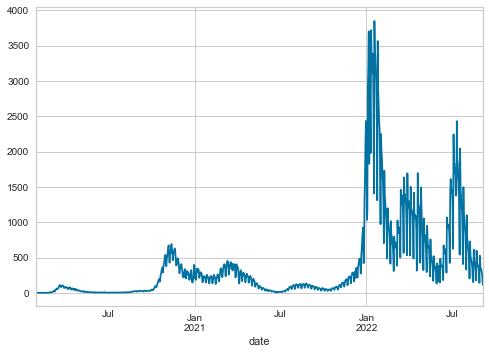

In [12]:
df_country['new_cases_per_million'].plot()

<AxesSubplot:xlabel='date'>

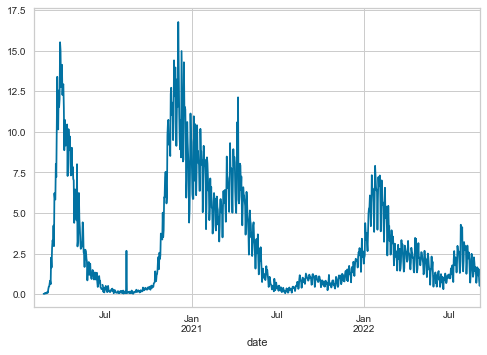

In [13]:
df_country['new_deaths_per_million'].plot()

<AxesSubplot:xlabel='date'>

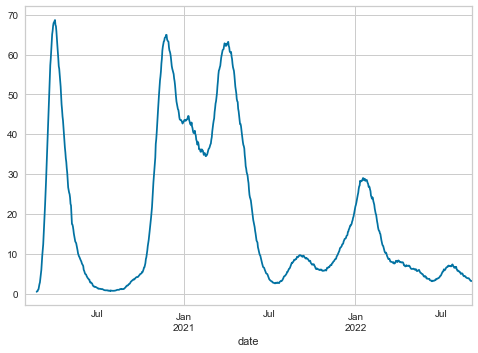

In [14]:
df_country['icu_patients_per_million'].plot()

In [15]:
# check missing data
df_country.isna().sum()

location                     0
new_cases_per_million        1
new_deaths_per_million      22
icu_patients_per_million    24
dtype: int64

In [16]:
# fill nas in ts
df_country = ts_filling(df_country)

In [17]:
# check missing data
df_country.isna().sum()

location                    0
new_cases_per_million       0
new_deaths_per_million      0
icu_patients_per_million    0
dtype: int64

<AxesSubplot:xlabel='date'>

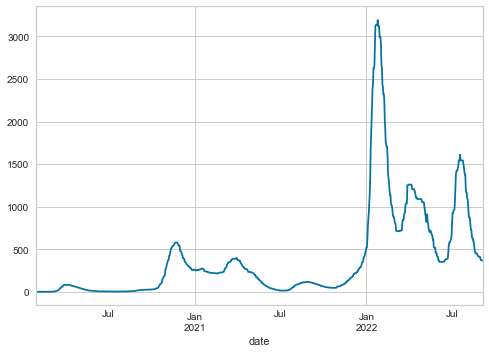

In [18]:
# smooth time series
df_country['new_cases_per_million'].plot()

<AxesSubplot:xlabel='date'>

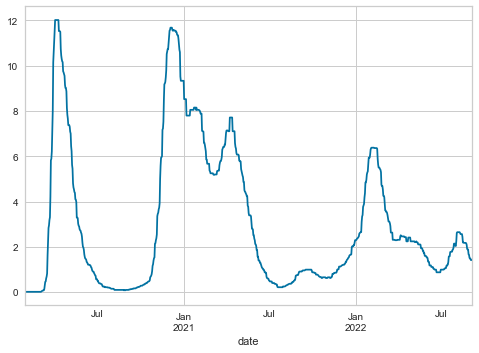

In [19]:
df_country['new_deaths_per_million'].plot()

<AxesSubplot:xlabel='date'>

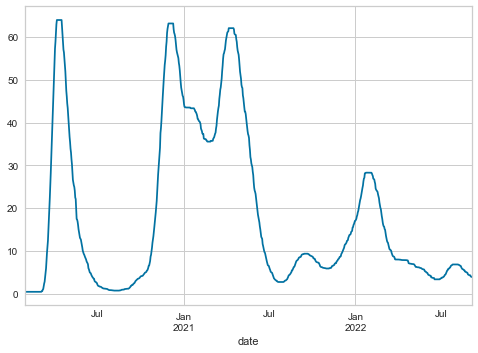

In [20]:
df_country['icu_patients_per_million'].plot()

# Feature Engineering

In [21]:
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million
date,,,,
2020-01-31,Italy,0.000,0.017,0.439
2020-02-01,Italy,0.000,0.017,0.439
2020-02-02,Italy,0.000,0.017,0.439
2020-02-03,Italy,0.000,0.017,0.439
2020-02-04,Italy,0.000,0.017,0.439
...,...,...,...,...
2022-09-01,Italy,371.284,1.485,4.304
2022-09-02,Italy,368.229,1.485,4.288
2022-09-03,Italy,368.026,1.418,4.034


In [22]:
# calculate new deaths percent change 
df_country = add_new_deaths_pct_change(df_country)
# calculate case fatality rate
df_country = add_case_fatality_rate(df_country)

In [23]:
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million,new_deaths_per_million_pct_change,case_fatality_rate
date,,,,,,
2020-01-31,Italy,0.000,0.017,0.439,0.000000,0.000000
2020-02-01,Italy,0.000,0.017,0.439,0.000000,0.000000
2020-02-02,Italy,0.000,0.017,0.439,0.000000,0.000000
2020-02-03,Italy,0.000,0.017,0.439,0.000000,0.000000
2020-02-04,Italy,0.000,0.017,0.439,0.000000,0.000000
...,...,...,...,...,...,...
2022-09-01,Italy,371.284,1.485,4.304,-0.323154,0.002775
2022-09-02,Italy,368.229,1.485,4.288,-0.318182,0.002800
2022-09-03,Italy,368.026,1.418,4.034,-0.348944,0.002800


<AxesSubplot:xlabel='date'>

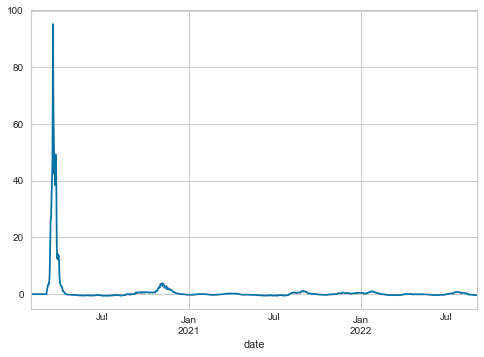

In [24]:
df_country['new_deaths_per_million_pct_change'].plot()

<AxesSubplot:xlabel='date'>

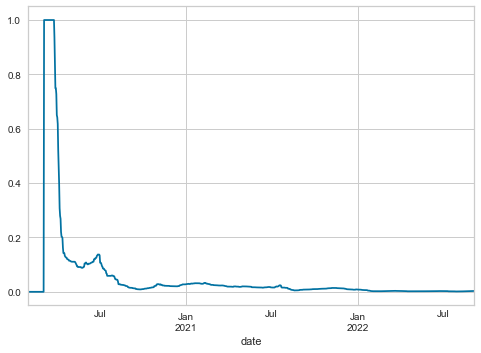

In [25]:
df_country['case_fatality_rate'].plot()

# Add Target

In [26]:
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million,new_deaths_per_million_pct_change,case_fatality_rate
date,,,,,,
2020-01-31,Italy,0.000,0.017,0.439,0.000000,0.000000
2020-02-01,Italy,0.000,0.017,0.439,0.000000,0.000000
2020-02-02,Italy,0.000,0.017,0.439,0.000000,0.000000
2020-02-03,Italy,0.000,0.017,0.439,0.000000,0.000000
2020-02-04,Italy,0.000,0.017,0.439,0.000000,0.000000
...,...,...,...,...,...,...
2022-09-01,Italy,371.284,1.485,4.304,-0.323154,0.002775
2022-09-02,Italy,368.229,1.485,4.288,-0.318182,0.002800
2022-09-03,Italy,368.026,1.418,4.034,-0.348944,0.002800


In [27]:
# add target i.e. deaths in 21 days
#df_country['new_deaths_per_million' + '_future'] = df_country['new_deaths_per_million'].shift(-14)
df_country['icu_patients_per_million' + '_future'] = df_country['icu_patients_per_million'].shift(-14)
df_country.dropna(axis=0, inplace=True)
df_country

,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million,new_deaths_per_million_pct_change,case_fatality_rate,icu_patients_per_million_future
date,,,,,,,
2020-01-31,Italy,0.000,0.017,0.439,0.000000,0.000000,0.439
2020-02-01,Italy,0.000,0.017,0.439,0.000000,0.000000,0.439
2020-02-02,Italy,0.000,0.017,0.439,0.000000,0.000000,0.439
2020-02-03,Italy,0.000,0.017,0.439,0.000000,0.000000,0.439
2020-02-04,Italy,0.000,0.017,0.439,0.000000,0.000000,0.439
...,...,...,...,...,...,...,...
2022-08-18,Italy,535.092,2.194,5.672,-0.161315,0.002018,4.304
2022-08-19,Italy,479.791,2.178,5.587,-0.178113,0.002102,4.288
2022-08-20,Italy,460.683,2.178,5.419,-0.178113,0.002121,4.034


In [28]:
# plot multiple time series with moving avgs in a loop
fig = px.line(df_country, x=df_country.index, y=['icu_patients_per_million'], title = country, template = 'plotly_dark')
fig.show()

# Simple Analytical Model

In [29]:
#df_country

In [30]:
## the simple model calculates the deaths simply as the new cases multiplied by the case fatality rate
#df_country['simple_prediction'] = df_country['new_cases_per_million'] * df_country['case_fatality_rate']
## apply some smoothing
#df_country['simple_prediction'] = df_country['simple_prediction'].rolling(14).median()
#df_country['simple_prediction'].fillna(value=None, method='bfill', axis=0, inplace=True, limit=30, downcast=None)
### drop nas
##df_country.dropna(axis=0, inplace=True)

In [31]:
#df_country

In [32]:
#df_country['new_deaths_per_million_future'].plot()
#df_country['simple_prediction'].plot()

# Train Test Split

In [33]:
df_train, df_test = train_test_split(df_country, split_date = '2021-11-01')

<AxesSubplot:xlabel='date'>

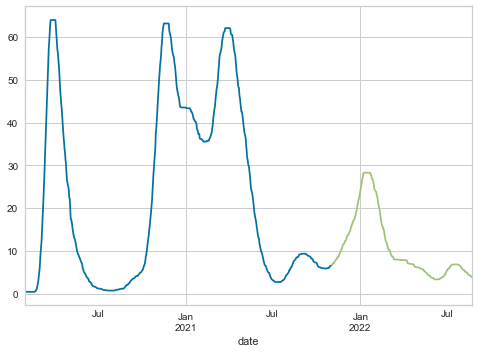

In [34]:
df_train['icu_patients_per_million_future'].plot()
df_test['icu_patients_per_million_future'].plot()

In [35]:
df_train.columns

Index(['location', 'new_cases_per_million', 'new_deaths_per_million',
       'icu_patients_per_million', 'new_deaths_per_million_pct_change',
       'case_fatality_rate', 'icu_patients_per_million_future'],
      dtype='object')

# Modeling

In [36]:
# initialize setup from pycaret.regression
s = setup(df_train, 
        target = 'icu_patients_per_million_future',
        ignore_features = ['location', 'new_cases_per_million', 'new_deaths_per_million_pct_change'],
        #ignore_features = ['location'],
        train_size = .99,
        data_split_shuffle = False, 
        fold_strategy = 'timeseries', fold=2,
        imputation_type = 'simple',
        numeric_imputation = 'median',
        remove_multicollinearity = True,
        multicollinearity_threshold = 0.4,
        feature_interaction=True,
        polynomial_features=False,
        remove_outliers = False,
        transform_target=False,
        transformation = False,
        normalize = False,
        feature_selection = False,
        feature_selection_method='boruta',
        feature_selection_threshold = 0.3,
        silent = True, 
        verbose = True, 
        session_id = 123)

,Description,Value
0,session_id,123
1,Target,icu_patients_per_million_future
2,Original Data,"(641, 7)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(634, 3)"


In [37]:
# compare all models and select best one based on MAE
best_model = compare_models(#include=['xgboost', 'dummy', 'lr', 'lightgbm'],
                            include=['xgboost', 'lightgbm'],
                            sort='R2', 
                            verbose=True,
                            n_select = 1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,21.0351,680.9889,25.4607,-0.8631,1.0979,1.1453,1.1500
xgboost,Extreme Gradient Boosting,21.9772,737.4352,26.5376,-1.0199,1.1104,1.1960,2.3150


In [38]:
best_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,25.8118,842.4048,29.0242,-1.1870,1.2400,0.8767
1,8.8170,111.5327,10.5609,0.6559,0.7073,1.1314
Mean,17.3144,476.9687,19.7926,-0.2655,0.9737,1.0040
Std,8.4974,365.4360,9.2317,0.9215,0.2664,0.1273


In [39]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [40]:
best_model = finalize_model(best_model)

In [41]:
df_train = predict_model(best_model, data=df_train)
df_test = predict_model(best_model, data=df_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,4.8633,52.7661,7.2640,0.8876,0.4686,0.8228


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.4377,32.6436,5.7135,0.4094,0.3388,0.2492


<AxesSubplot:xlabel='date'>

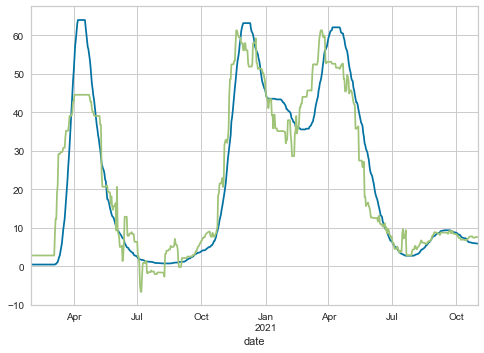

In [42]:
df_train['icu_patients_per_million'].plot()
df_train['Label'].plot()

<AxesSubplot:xlabel='date'>

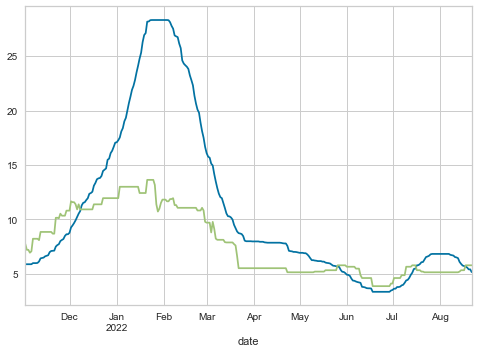

In [43]:
df_test['icu_patients_per_million'].plot()
df_test['Label'].plot()

In [44]:
df_country = predict_model(best_model, data=df_country)
df_country.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,4.4151,46.4388,6.8146,0.8743,0.4320,0.6425


,location,new_cases_per_million,new_deaths_per_million,icu_patients_per_million,new_deaths_per_million_pct_change,case_fatality_rate,icu_patients_per_million_future,Label
date,,,,,,,,
2020-01-31,Italy,0.0,0.017,0.439,0.0,0.0,0.439,2.800444
2020-02-01,Italy,0.0,0.017,0.439,0.0,0.0,0.439,2.800444
2020-02-02,Italy,0.0,0.017,0.439,0.0,0.0,0.439,2.800444
2020-02-03,Italy,0.0,0.017,0.439,0.0,0.0,0.439,2.800444
2020-02-04,Italy,0.0,0.017,0.439,0.0,0.0,0.439,2.800444


In [45]:
fig = px.line(df_country, x=df_country.index, y=['icu_patients_per_million',
                                                 'Label'], title = country, template = 'plotly_dark')
fig.show()

# ToDo

In [46]:
# download once per day and store in data folder-------------------ok
# predict hospitalization----------------------------------ok
# drop countries with too much missing data-----------------------ok
# correct forecast on time axis-----------------------ok
# show train test split in final figure
# make streamlit app and deploy with ci/cd